Here, we first visualize the already trained CNN (VGG and AlexNet): their filters, weights, and activations. Then, to visulize what are the critical features on an example image, we use Occlusion, Saliency map, and SmoothGrad to generate a heatmap of important features (pixels).

In [ ]:
# This notebook needs GPU
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
imageDir = '/content/drive/Shared drives/nma_dl_conv_ok/data/egImages/'
outputDir = '/content/drive/Shared drives/nma_dl_conv_ok/visualizations/'

Mounted at /content/drive


In [ ]:
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import json

In [ ]:
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

In [ ]:
def normalize(image):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
    image = Variable(preprocess(image).unsqueeze(0).cuda())
    return image


def predict(image):
    _, index = vgg(image).data[0].max(0)
    return str(index[0]), labels[str(index[0])][1]
    
def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

In [ ]:
!pip install decord
from decord import VideoReader
from decord import cpu
def sample_video_from_mp4(file, num_frames=16):
    """This function takes a mp4 video file as input and returns
    a list of uniformly sampled frames (PIL Image).
    Parameters
    ----------
    file : str
        path to mp4 video file
    num_frames : int
        how many frames to select using uniform frame sampling.
    Returns
    -------
    images: list of PIL Images
    num_frames: int
        number of frames extracted
    """
    images = list()
    vr = VideoReader(file, ctx=cpu(0))
    total_frames = len(vr)
    indices = np.linspace(0,total_frames-1,num_frames,dtype=np.int)
    for seg_ind in indices:
        images.append(Image.fromarray(vr[seg_ind].asnumpy()))

    return images,num_frames

     |████████████████████████████████| 13.6 MB 78 kB/s 


In [ ]:
import glob

#@title Visualize video
vid_id = 27 #@param {type: "integer"}
video_dir = '/content/drive/Shared drives/nma_dl_conv_ok/data/participants_data/AlgonautsVideos268_All_30fpsmax'

########### Video display code #################################################
video_list = glob.glob(video_dir + '/*.mp4')
video_list.sort()

#visualize_brain_activity(video_dir,fmri_train_all,vid_id)
from IPython.display import HTML
from base64 import b64encode

mp4 = open(video_list[vid_id],'rb').read()

In [ ]:
# Alternative way to view image from video
# inputImage2=VideoReader(video_list[27], ctx=cpu(0))[1].asnumpy()
# inputImage2.shape

Read a new frame:  True


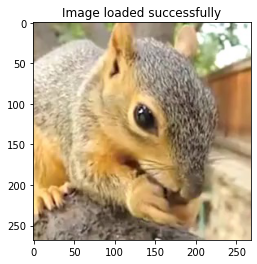

In [ ]:
import cv2
vidcap = cv2.VideoCapture(video_list[27])
success,image = vidcap.read()
frame_id = 0 # total 90 frames
cv2.imwrite(imageDir + "squirrel_frame%d.jpg" % frame_id, image)     # save frame as JPEG file      
print('Read a new frame: ', success)
squirrel_1 = load_image(imageDir + "squirrel_frame0.jpg")
squirrel_2 = normalize(squirrel_1)

In [ ]:
# # Original example
# kitten_1 = load_image("./images/kitten_1.jpg")
# kitten_2 = normalize(kitten_1)

In [ ]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
modulelist = list(vgg.features.modules())
print(len(modulelist))

32


# Output of various layers

In [ ]:
def layer_outputs(image):
    outputs = []
    names = []
    for i,layer in enumerate(modulelist[1:]):
        image = layer(image)
        outputs.append(image)
        names.append(str(i) + ' ' + str(layer))
        
    output_im = []
    for i in outputs:
        i = i.squeeze(0)
        temp = to_grayscale(i)
        output_im.append(temp.data.cpu().numpy())
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (50, 30)


    for i in range(len(output_im)):
        a = fig.add_subplot(4,8,i+1)
        imgplot = plt.imshow(output_im[i])
        plt.axis('off')
        a.set_title(names[i].partition('(')[0], fontsize=30)



In [ ]:
# layer_outputs(kitten_2)
# plt.savefig(outputDir + 'VGG16_layer_outputs_kitten.jpg', bbox_inches='tight')

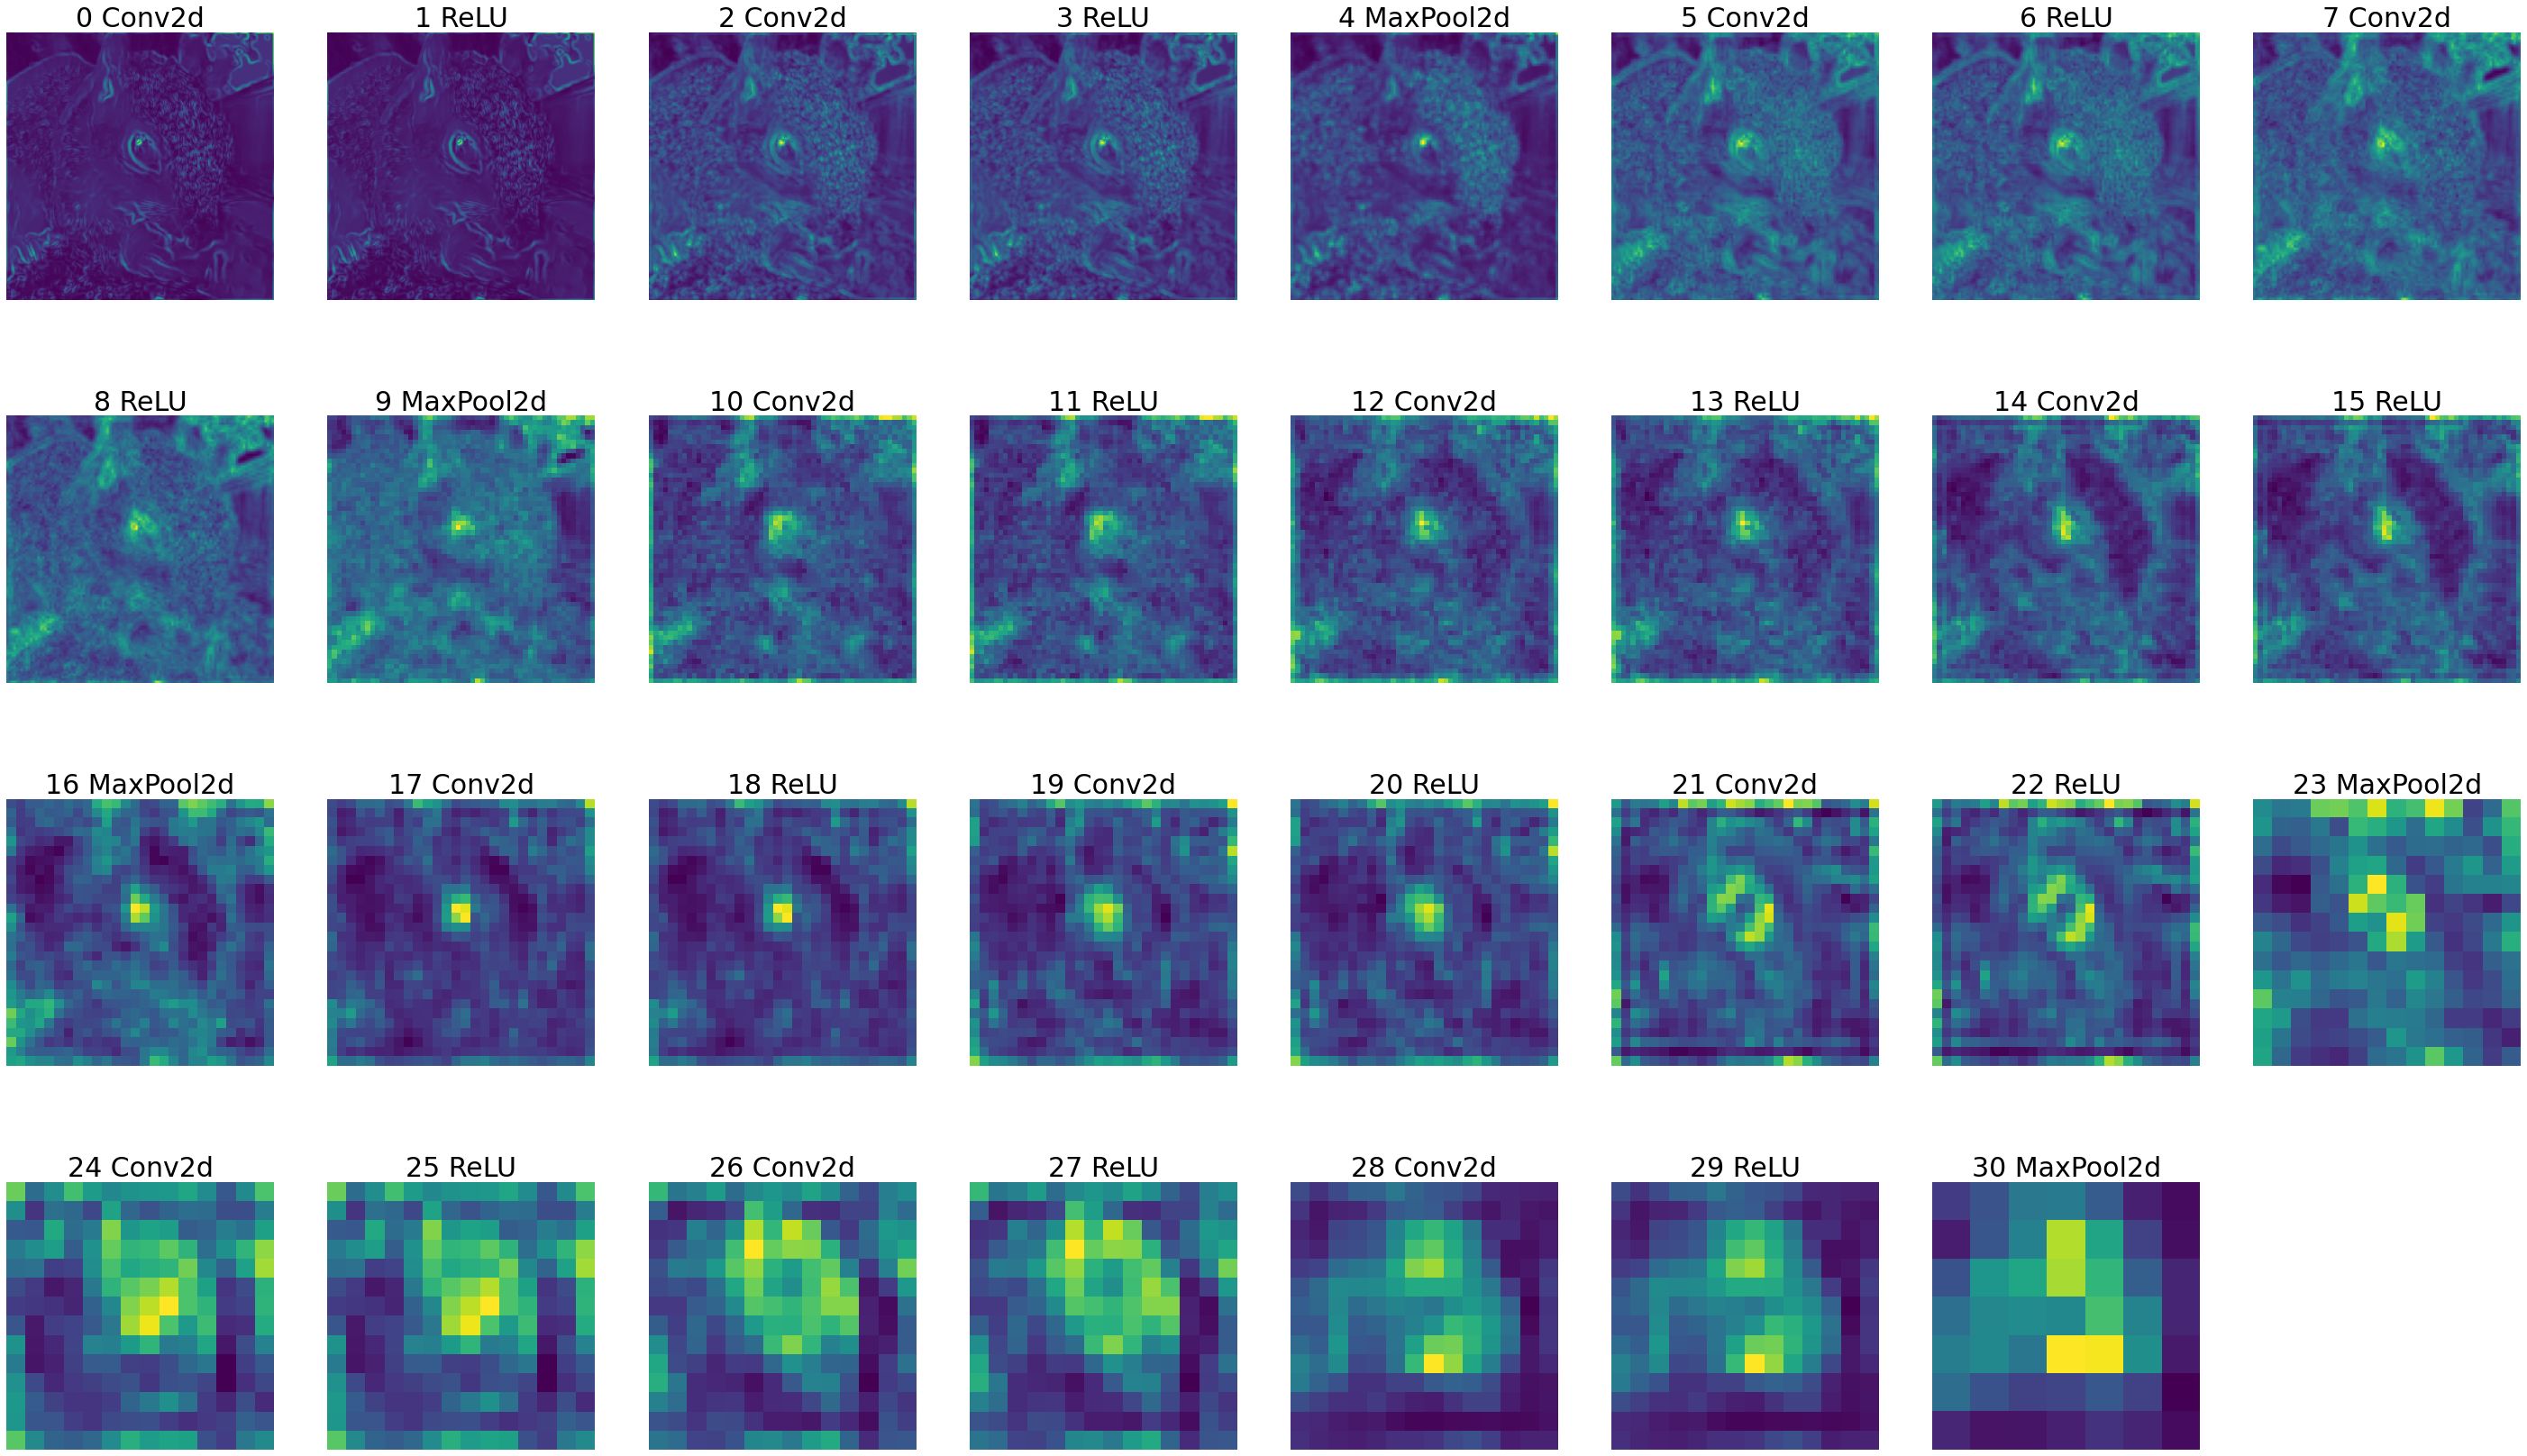

In [ ]:
layer_outputs(squirrel_2)
plt.savefig(outputDir + 'VGG16_layer_outputs_squirrel.jpg', bbox_inches='tight')

In [ ]:
# Load Alexnet
alexnet = models.alexnet(pretrained=True)
alexnet = alexnet.cuda()
print(alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
modulelist = list(alexnet.features.modules())
print(len(modulelist))

14


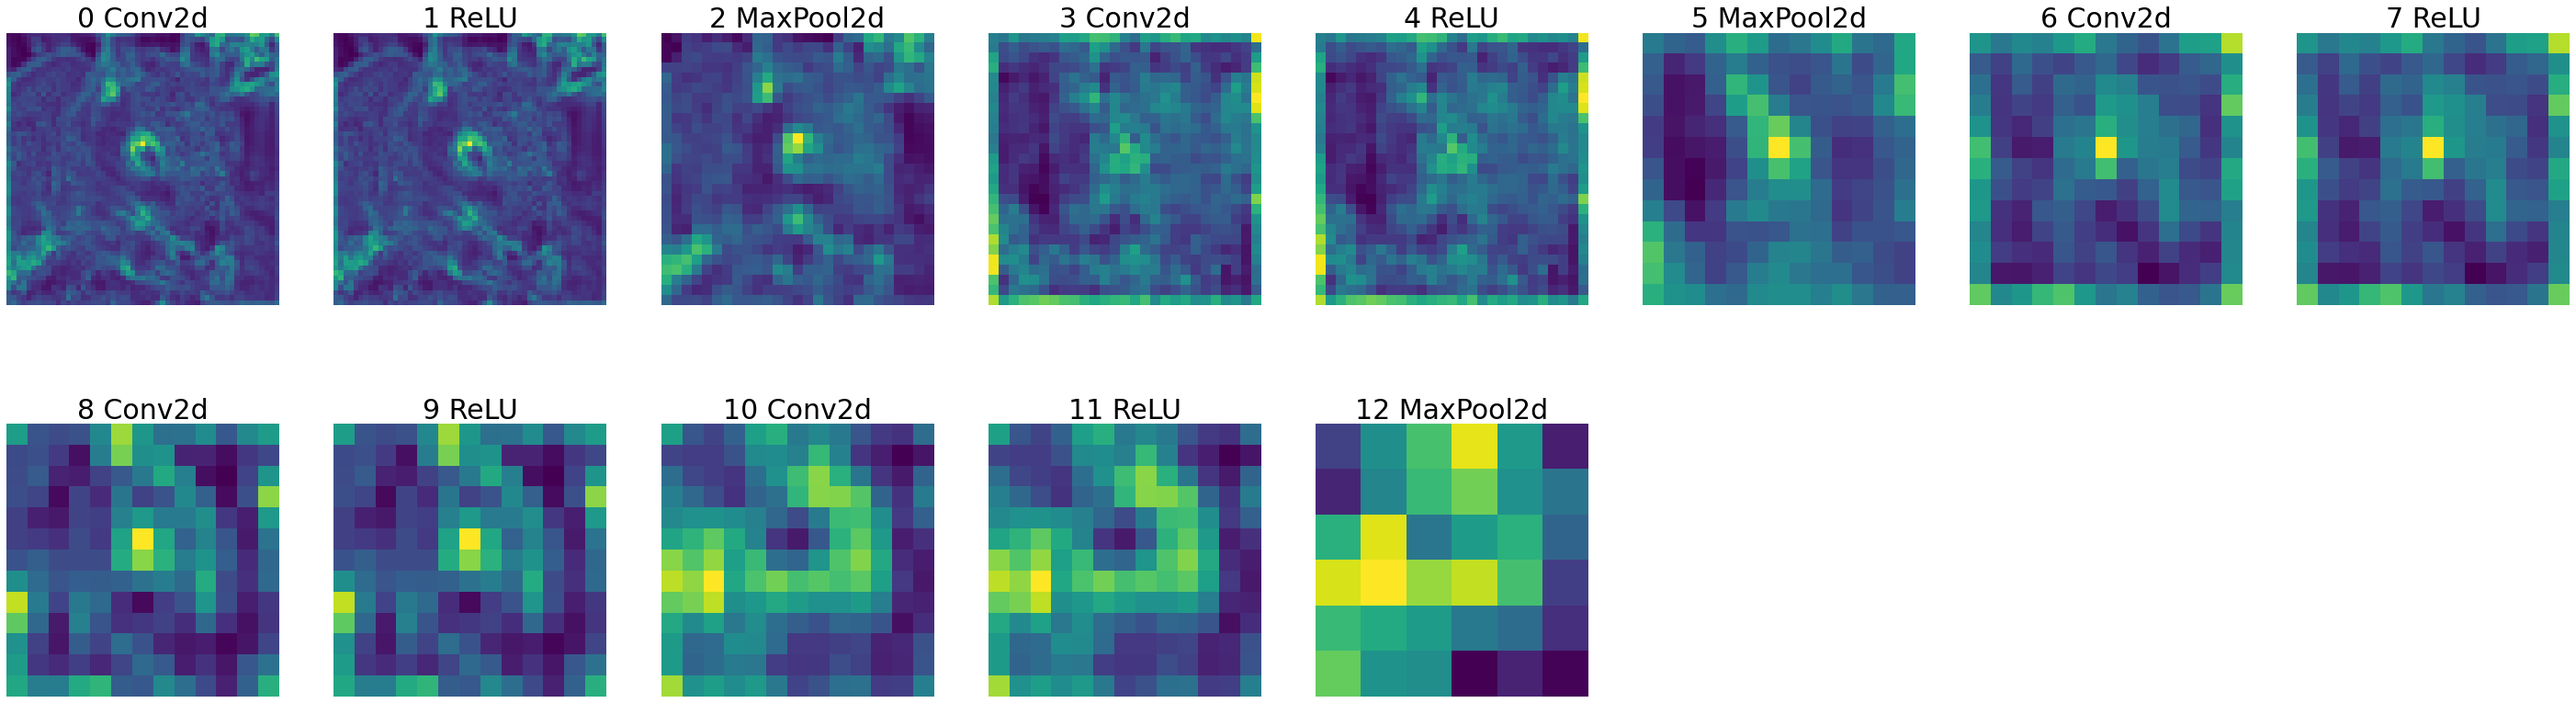

In [ ]:
layer_outputs(squirrel_2)
plt.savefig(outputDir + 'Alexnet_layer_outputs_squirrel.jpg', bbox_inches='tight')

# Output of each filter separately at given layer

In [ ]:
def filter_outputs(image, layer_to_visualize):
    if layer_to_visualize < 0:
        layer_to_visualize += len(modulelist) -1 # AH: the last layer of vgg is 31
    output = None
    name = None
    for count, layer in enumerate(modulelist[1:]):
        image = layer(image)
        if count == layer_to_visualize: 
            output = image
            name = str(layer)
    
    filters = []
    output = output.data.squeeze()
    for i in range(output.shape[0]):
        filters.append(output[i,:,:])
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (10, 10)

    for i in range(int(np.sqrt(len(filters))) * int(np.sqrt(len(filters)))):
        fig.add_subplot(np.sqrt(len(filters)), np.sqrt(len(filters)),i+1)
        imgplot = plt.imshow(filters[i].cpu())
        plt.axis('off')
    
    # print(len(filters))
    # print(filters[0].shape)   
            
    # print(output.shape)

In [ ]:
# filter_outputs(kitten_2, 0)
# plt.savefig('filter_Layer0_kitten.jpg', bbox_inches='tight')


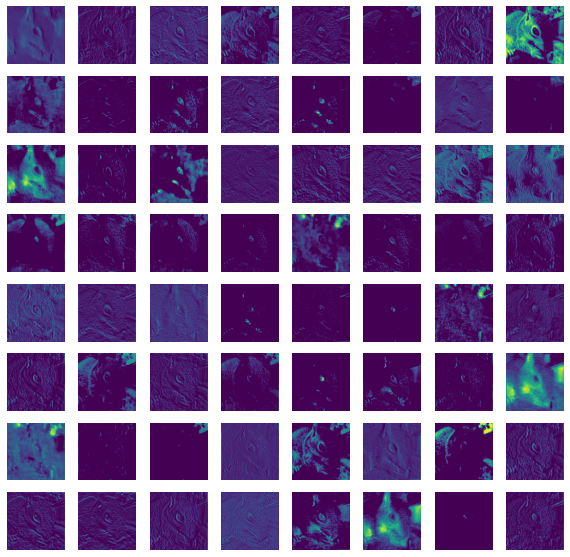

In [ ]:
modulelist = list(vgg.features.modules()) # set current modulelist to vgg
filter_outputs(squirrel_2, 0)
plt.savefig(outputDir + 'VGG16_filter_Layer0_squirrel.jpg', bbox_inches='tight')

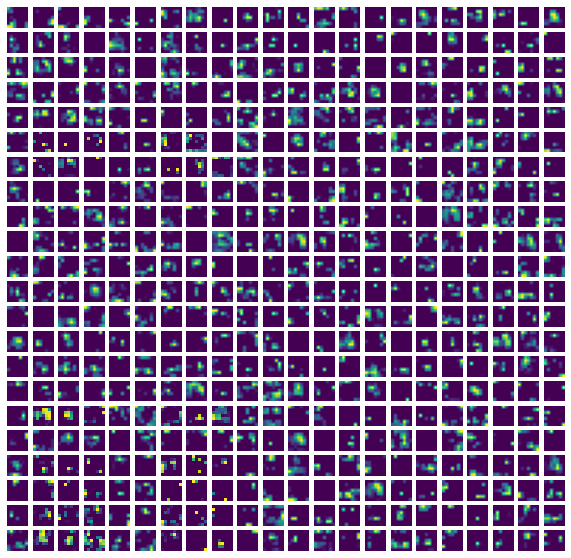

In [ ]:
filter_outputs(squirrel_2, -1)
plt.savefig(outputDir + 'VGG16_filter_Layer-1_squirrel.jpg', bbox_inches='tight')

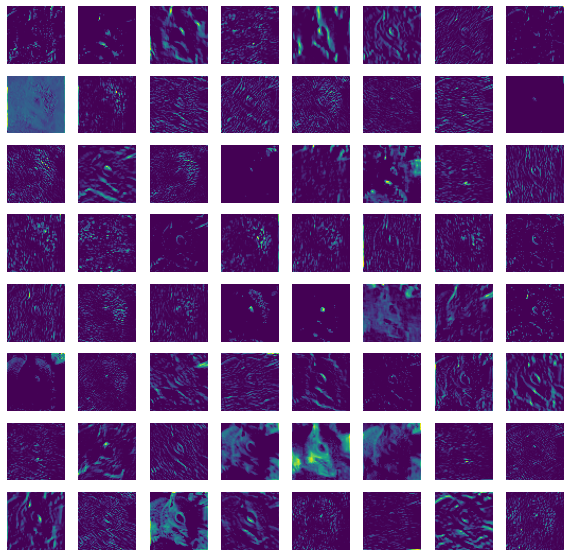

In [ ]:
modulelist = list(alexnet.features.modules())
filter_outputs(squirrel_2, 0)
plt.savefig(outputDir + 'Alexnet_filter_Layer0_squirrel.jpg', bbox_inches='tight')

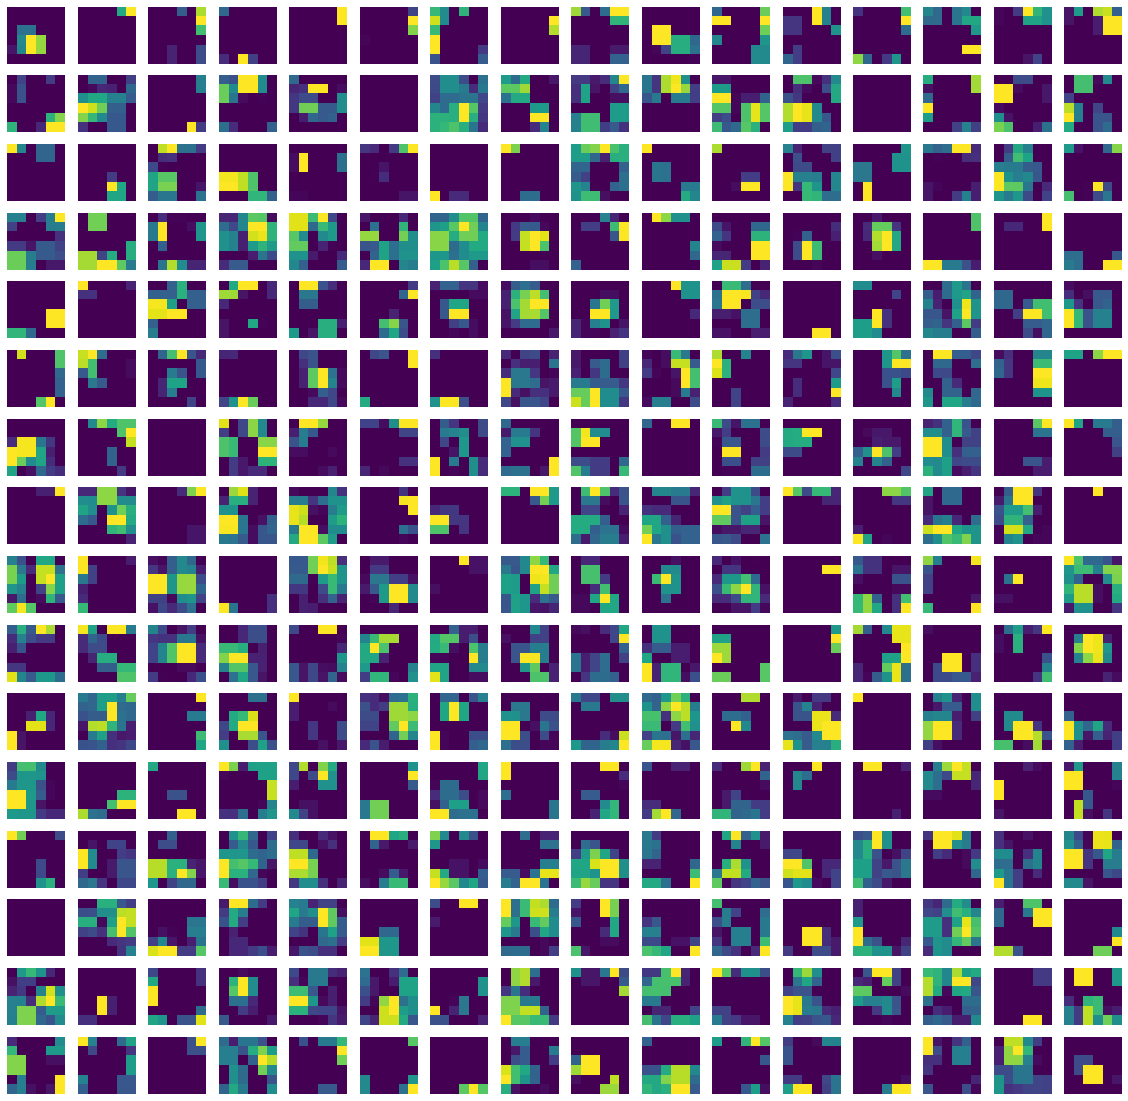

In [ ]:
layerID = 12 # last FC layer of Alexnet
filter_outputs(squirrel_2, layerID)
plt.savefig(outputDir + 'Alexnet_filter_Layer' + str(layerID) + '_squirrel.jpg', bbox_inches='tight')

# Visualize weights

In [ ]:
def visualize_weights(model, layer):
    weight_used = []
    for w in model.features.children():
        if isinstance(w, torch.nn.modules.conv.Conv2d):
            weight_used.append(w.weight.data)

    filters = []
    for i in range(weight_used[layer].shape[0]):
        filters.append(weight_used[layer][i,:,:,:].sum(dim=0))
        filters[i].div(weight_used[layer].shape[1])
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (10, 10)
    for i in range(int(np.sqrt(weight_used[layer].shape[0])) * int(np.sqrt(weight_used[layer].shape[0]))):
        a = fig.add_subplot(np.sqrt(weight_used[layer].shape[0]),np.sqrt(weight_used[layer].shape[0]),i+1)
        imgplot = plt.imshow(filters[i].cpu())
        plt.axis('off')

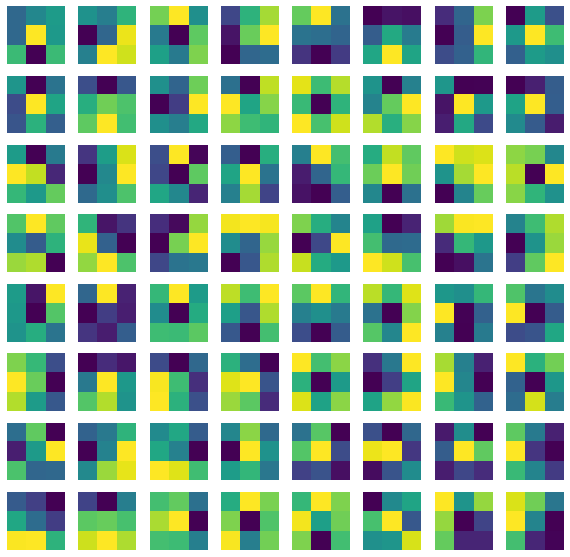

In [ ]:
# First conv layer filters
visualize_weights(vgg, 0)
plt.savefig(outputDir + 'VGG16_weights_Layer0', bbox_inches='tight')

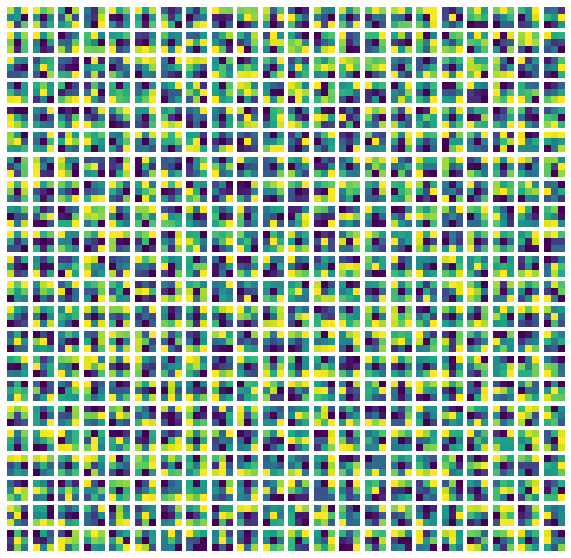

In [ ]:
# Last conv layer filters
visualize_weights(vgg, -1)
plt.savefig(outputDir + 'VGG16_weights_Layer-1', bbox_inches='tight')

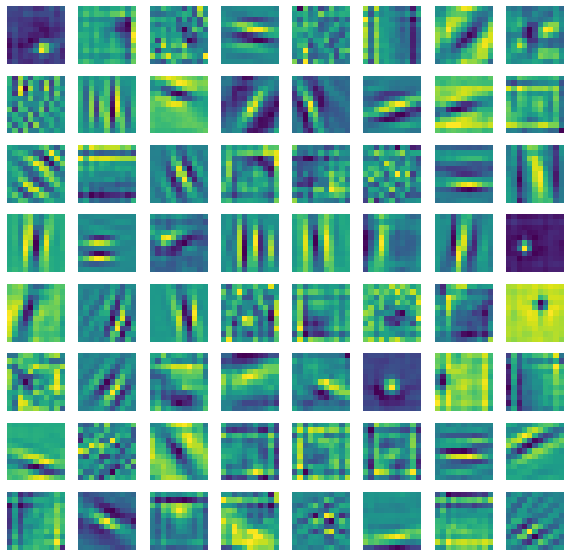

In [ ]:
# First conv layer filters
visualize_weights(alexnet, 0)
plt.savefig(outputDir + 'Alexnet_weights_Layer0', bbox_inches='tight')

# CNN Heatmaps : Occlusion

In [ ]:
def make_heatmap(model, image, true_class, k=8, stride=8): 
    """
    Input image is of size (1, c, w, h) typically (1, 3, 224, 224) for vgg16
    true_class is a number corresponding to imagenet classes
    k in the filter size (c, k, k)
    """
    heatmap = torch.zeros(int(((image.shape[2]-k)/stride)+1), int(((image.shape[3]-k)/stride)+1))
    image = image.data

    i = 0
    a = 0
    while i<=image.shape[3]-k:
        j = 0 
        b = 0
        while j<=image.shape[2]-k:
            h_filter = torch.ones(image.shape)
            h_filter[:,:,j:j+k, i:i+k] = 0
            temp_image = Variable((image.cuda() * h_filter.cuda()).cuda())
            temp_softmax = model(temp_image)
            temp_softmax = torch.nn.functional.softmax(temp_softmax).data[0]
            heatmap[a][b] = temp_softmax[true_class]
            j += stride
            b += 1
        print(a, end =" ")
        i += stride
        a += 1
    
    image = image.squeeze()
    
    true_image = image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    # Un-Normalize image
    true_image = true_image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()
    
    # Plot both images
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)
    
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image.cpu())
    plt.title('Original Image')
    plt.axis('off') 
    
    # Normalize heatmap
    heatmap = heatmap - heatmap.min()
#     heatmap = heatmap/heatmap.max()
    heatmap = np.uint8(255 * heatmap)
    
    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off') 
    
    return heatmap
                    

torch.Size([1, 3, 224, 224])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 

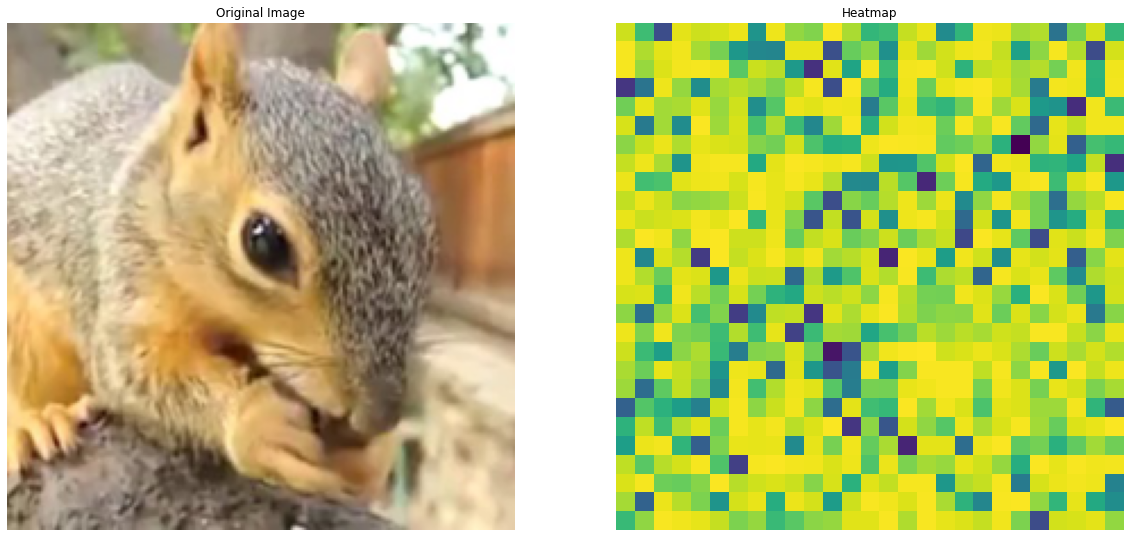

In [ ]:
# heatmap is just pure purple, not sure what it means
my_img = squirrel_2
print(my_img.data.shape) # 1x3x224x224
squirrel_heatmap = make_heatmap(vgg, my_img, 335, 16, 8)  # Extremely slow
plt.savefig(outputDir + 'VGG16_occlusion_squirrel')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 

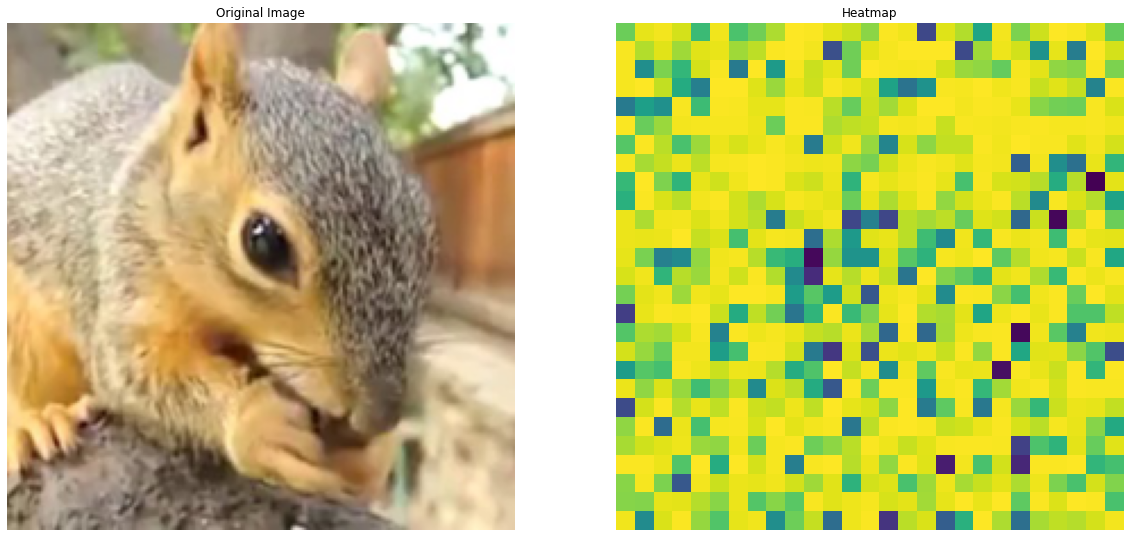

In [ ]:
squirrel_heatmap = make_heatmap(alexnet, my_img, 335, 16, 8)  # Extremely slow
plt.savefig(outputDir + 'Alexnet_occlusion_squirrel')

In [ ]:
normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])

In [ ]:
def make_saliency_map(model, input, label):
    input = Variable(preprocess(input).unsqueeze(0).cuda(), requires_grad=True)
    output = model.forward(input)
    output[0][label].backward()
    grads = input.grad.data.clamp(min=0)
    grads.squeeze_()
    grads.transpose_(0,1)
    grads.transpose_(1,2)
    grads = np.amax(grads.cpu().numpy(), axis=2)
    
    true_image = input.data
    true_image = true_image.squeeze()
    true_image = true_image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = deprocess(true_image)

    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)


    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image.cpu())
    plt.title('Original Image')
    plt.axis('off') 

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads)
    plt.axis('off') 
    plt.title('Saliency Map')
    
    return grads

In [ ]:
# # original example
# dog = load_image('images/retr.jpeg')
# dog_sal = make_saliency_map(dog, 207)
# goldfish = load_image('images/goldfish.jpg')
# goldfish_sal = make_saliency_map(goldfish, 1)

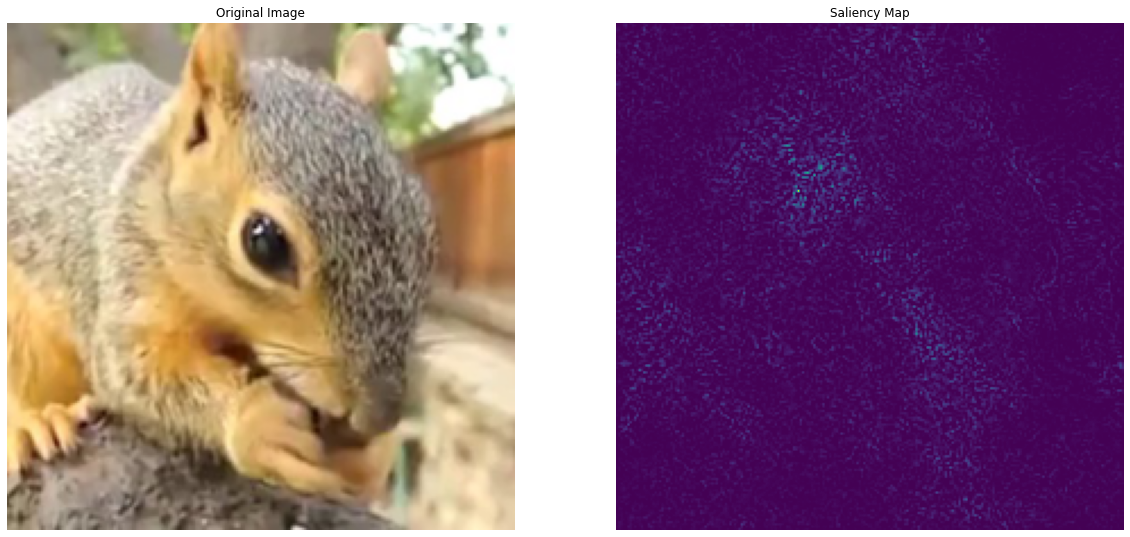

In [ ]:
squirrel_sal = make_saliency_map(vgg, squirrel_1, 335)
plt.savefig(outputDir + 'VGG16_saliency_squirrel')

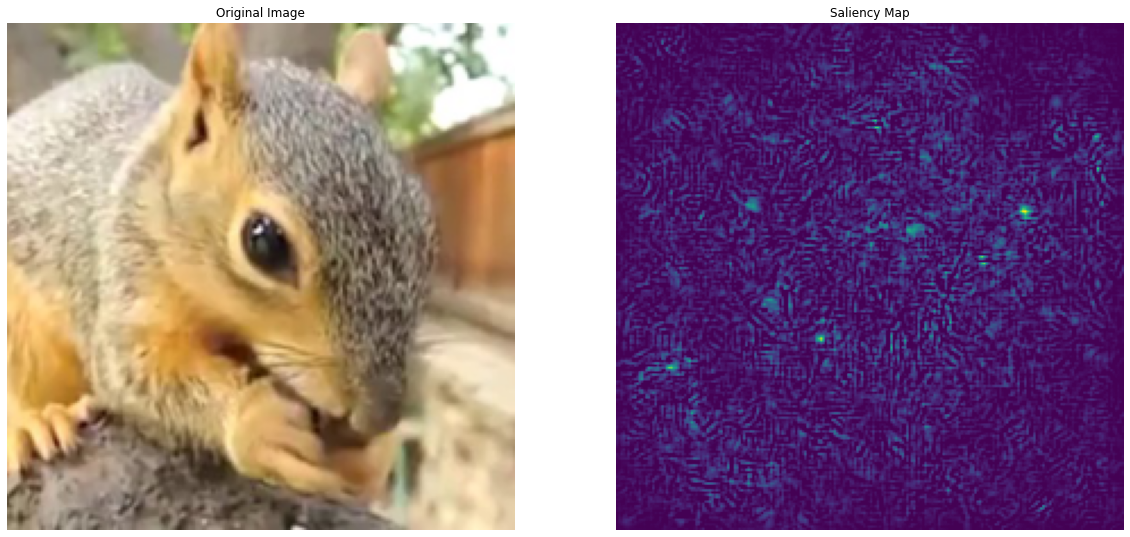

In [ ]:
squirrel_sal = make_saliency_map(alexnet, squirrel_1, 335)
plt.savefig(outputDir + 'Alexnet_saliency_squirrel')

# SmoothGrad

In [ ]:
def smooth_grad(model, input, label, x=10, percent_noise=10):
    """
    The apparent noise one sees in a sensitivity map may be due to 
    essentially meaningless local variations in partial derivatives.
    After all, given typical training techniques there is no reason to expect derivatives to vary smoothly.
    """
    tensor_input = torch.from_numpy(np.array(input)).type(torch.cuda.FloatTensor) # input is now of shape (w,h,c)
    
    # x is the sample size
    final_grad = torch.zeros((1,3,224,224)).cuda()
    for i in range(x):
        print('Sample:', i+1, end=" ")
        temp_input = tensor_input
        # According to the paper, noise level corrresponds to stddev/(xmax-xmin). Hence stddev = noise_percentage * (max-min) /100
        # AH: add .cpu() to tensor_input.max()
        noise = torch.from_numpy(np.random.normal(loc=0, scale=(percent_noise/100) * (tensor_input.max().cpu() - tensor_input.min().cpu()), size=temp_input.shape)).type(torch.cuda.FloatTensor)
        temp_input = (temp_input + noise).cpu().numpy()
        temp_input = Image.fromarray(temp_input.astype(np.uint8))
        temp_input = Variable(preprocess(temp_input).unsqueeze(0).cuda(), requires_grad=True)

        output = model.forward(temp_input)
        output[0][label].backward()
        final_grad += temp_input.grad.data
    
    grads = final_grad/x
    grads = grads.clamp(min=0)
    grads.squeeze_()
    grads.transpose_(0,1)
    grads.transpose_(1,2)
    grads = np.amax(grads.cpu().numpy(), axis=2)
    
    true_image = normalize(input)
    true_image = true_image.squeeze()
    true_image = true_image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = deprocess(true_image.data)

    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)


    a = fig.add_subplot(1,2,1)
    # AH: add .cpu() 
    imgplot = plt.imshow(true_image.cpu())
    plt.title('Original Image')
    plt.axis('off') 

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads)
    plt.axis('off')  
    plt.title('SmoothGrad, Noise: ' + str(percent_noise) + '%, ' + 'Samples: ' + str(x))
    
    return grads

In [ ]:
# # Original example
# dog_sg = load_image('images/retr.jpeg')
# dog_sal = make_saliency_map(dog_sg, 1)
# dog_sg_sal = smooth_grad(dog, 207, 30, 10)

# flamingo_sg = load_image('images/flamingo.jpg')
# flamingo_sal = make_saliency_map(flamingo_sg, 130)
# flamingo_sg_sal = smooth_grad(flamingo_sg, 130, 20, 20)

Sample: 1 Sample: 2 Sample: 3 Sample: 4 Sample: 5 Sample: 6 Sample: 7 Sample: 8 Sample: 9 Sample: 10 Sample: 11 Sample: 12 Sample: 13 Sample: 14 Sample: 15 Sample: 16 Sample: 17 Sample: 18 Sample: 19 Sample: 20 Sample: 21 Sample: 22 Sample: 23 Sample: 24 Sample: 25 Sample: 26 Sample: 27 Sample: 28 Sample: 29 Sample: 30 

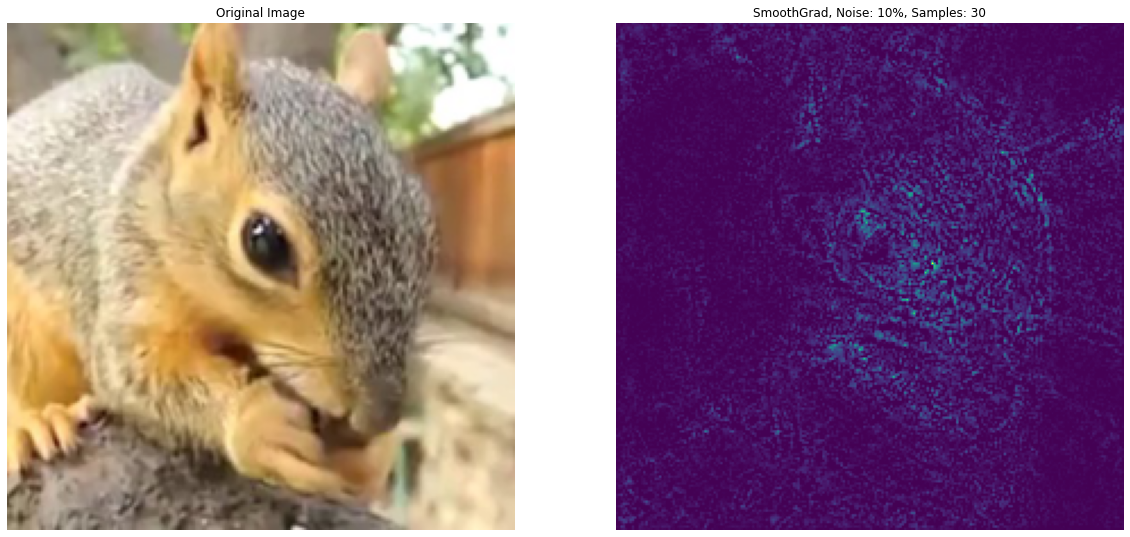

In [ ]:
squirrel_sg_sal = smooth_grad(vgg, squirrel_1, 335, 30, 10)
plt.savefig(outputDir + 'VGG16_smoothGrad_squirrel')

Sample: 1 Sample: 2 Sample: 3 Sample: 4 Sample: 5 Sample: 6 Sample: 7 Sample: 8 Sample: 9 Sample: 10 Sample: 11 Sample: 12 Sample: 13 Sample: 14 Sample: 15 Sample: 16 Sample: 17 Sample: 18 Sample: 19 Sample: 20 Sample: 21 Sample: 22 Sample: 23 Sample: 24 Sample: 25 Sample: 26 Sample: 27 Sample: 28 Sample: 29 Sample: 30 

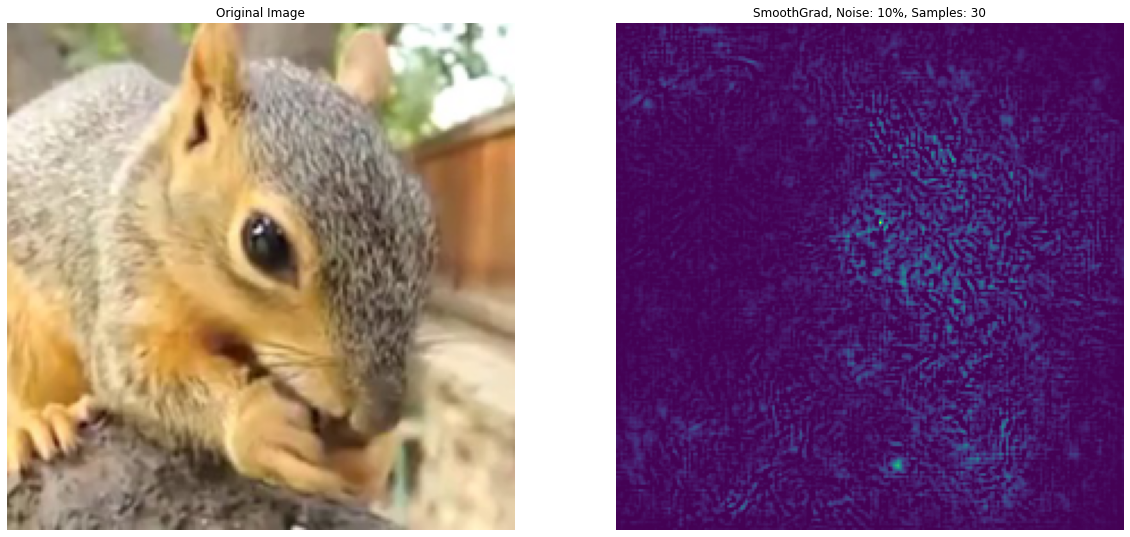

In [ ]:
squirrel_sg_sal = smooth_grad(alexnet, squirrel_1, 335, 30, 10)
plt.savefig(outputDir + 'Alexnet_smoothGrad_squirrel')

# Class Models (not sure how to interpret the result)

In [ ]:
def make_class_map(label, iterations=100, lr=250, reg=1):
    cmap = np.zeros((224,224,3))
    mean = np.array([0.485, 0.456, 0.406])
    cmap += mean
#     plt.imshow(map)
    cmap = cmap.transpose(2,1,0)
    cmap = Variable(torch.Tensor(cmap).unsqueeze(0).cuda(), requires_grad=True)
#     cmap.data.shape
    for i in range(iterations):
    
        vgg.zero_grad()
        output = vgg(cmap)
#         print(i+1)
        class_score = output[0][label]
        reg_out = class_score + reg * cmap.norm()
        reg_out.backward()

        cmap.data = cmap.data + lr * cmap.grad.data
        
        
    cmap = cmap.data.squeeze()
    cmap.transpose_(0,1)
    cmap.transpose_(1,2)
    cmap = np.clip(np.array(deprocess(cmap).cpu()),0,255).astype('uint8')
    plt.figure(figsize=(5,5))
    plt.imshow(cmap)
    plt.axis('off')

    plt.title(labels[str(label)][1])
    
    return cmap


In [ ]:
# Original example
flamingo_cmap = make_class_map(130, 1000, 300, 0.5)
dumbbell_cmap = make_class_map(543, 1000, 300, 0.5)

# Visualize Alexnet

In [ ]:
plot_weights(alexnet, 0, single_channel = False)